In [48]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.tsa.statespace.varmax import VARMAX

To start off with, we can look at the Strava data provided by Nick and see whether it is usable.

In [3]:
nick_data = pd.read_csv('/Users/aayush/Documents/Run4It/Run4It/Model/Data/activities.csv')
nick_data['Activity Date'] = pd.to_datetime(nick_data['Activity Date'], format='%d %b %Y, %H:%M:%S')
nick_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 78 columns):
 #   Column                                                                                          Non-Null Count  Dtype         
---  ------                                                                                          --------------  -----         
 0   Activity ID                                                                                     225 non-null    int64         
 1   Activity Date                                                                                   225 non-null    datetime64[ns]
 2   Activity Name                                                                                   225 non-null    object        
 3   Activity Type                                                                                   225 non-null    object        
 4   Activity Description                                                                            10

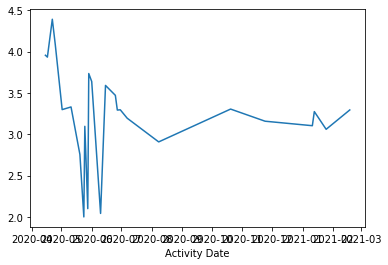

,Activity ID,Elapsed Time,Distance,Relative Effort,Commute,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,...,Precipitation Probability,Precipitation Type,Cloud Cover,Weather Visibility,UV Index,Weather Ozone,translation missing: en-GB.lib.export.portability_exporter.activities.horton_values.jump_count,translation missing: en-GB.lib.export.portability_exporter.activities.horton_values.total_grit,translation missing: en-GB.lib.export.portability_exporter.activities.horton_values.avg_flow,translation missing: en-GB.lib.export.portability_exporter.activities.horton_values.flagged
Activity Date,,,,,,,,,,,,,,,,,,,,,
2020-11-24,4.382888e+09,1306.0,4.12,51.0,False,NaN,NaN,1306.0,1306.0,4125.799805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-11,4.605215e+09,1655.0,5.08,66.0,False,NaN,NaN,1655.0,1639.0,5088.600098,...,0.0,NaN,0.94,16093.0,0.0,280.700012,NaN,NaN,NaN,NaN
2021-01-13,4.616426e+09,666.0,2.18,26.0,False,NaN,NaN,666.0,666.0,2181.500000,...,0.0,NaN,0.99,0.0,0.0,256.000000,NaN,NaN,NaN,NaN
2021-01-25,4.680552e+09,1663.0,5.08,42.0,False,NaN,NaN,1663.0,1662.0,5087.600098,...,0.0,NaN,0.28,16093.0,0.0,381.899994,NaN,NaN,NaN,NaN
2021-02-18,4.805674e+09,1524.0,5.02,91.0,False,NaN,NaN,1524.0,1524.0,5022.299805,...,0.0,NaN,0.92,16093.0,0.0,435.100006,NaN,NaN,NaN,NaN


In [29]:
# Grouping by day and only looking at bike rides 
run = nick_data[nick_data['Activity Type']=='Run'].groupby(nick_data['Activity Date'].dt.date).mean()
run['Average Speed'].plot()
run.tail()

Strava data from Nick: Limited for ML purposes due to the low volume of data. Not enough to accurately make predictions. Potentially can synthesise results using this and use that data for POC. Easier way to synthesise nutrition data as well, because we know roughly what Nick eats on a regular basis. Also have Gousto information available.

In [70]:
# Missing data for some of the timesteps: We can just use interpolate method to impute these for now 
print(f'first date {run.index[0]}, last date {run.index[-1]}')

# Data ranging from 2020-04-15 to 2021-02-18
date_range = pd.DataFrame(index=pd.date_range(start='2020-04-15', end='2021-02-18'))
run_full = date_range.join(run, how='left')

first date 2020-04-15, last date 2021-02-18


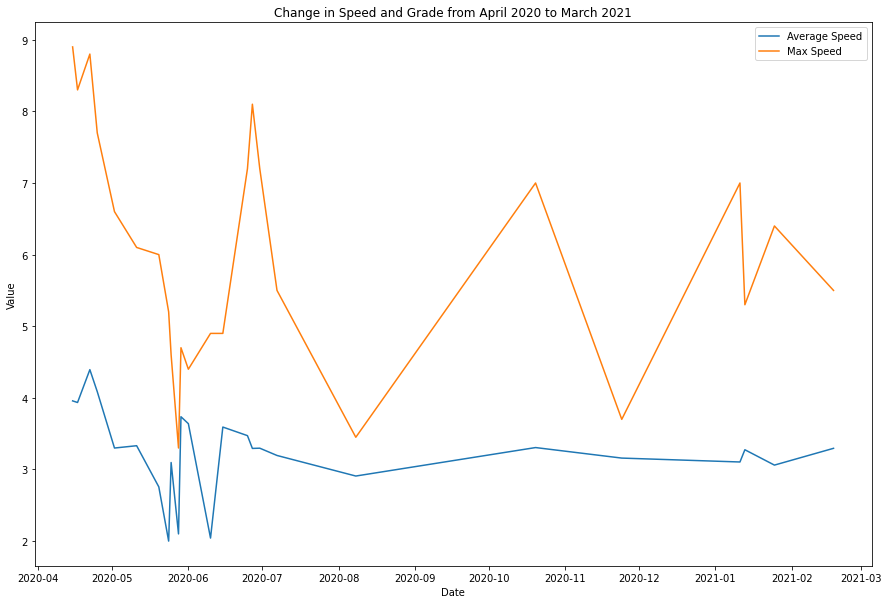

Text(0.5, 1.0, 'Change in Speed and Grade from April 2020 to March 2021')

In [89]:
# Missing data imputation, to help with synthesising in a more accurate way. 
cols_of_interest = ['Average Speed','Max Speed']
run_full[cols_of_interest] = run_full[cols_of_interest].interpolate()

fig, ax = plt.subplots(nrows=1, figsize=(15,10))
ax.plot(run_full.index, run_full[cols_of_interest])
ax.legend(cols_of_interest)
ax.set_ylabel('Value')
ax.set_xlabel('Date')
ax.set_title('Change in Speed and Grade from April 2020 to March 2021')

In [90]:
#TODO: Next, we use a simple forecaster model to forecast this data forward, so that we have a larger synthesised dataset, lets start with a simple moving average model
model = VARMAX(run_full[cols_of_interest])
results = model.fit(maxiter=1000, disp=False)
results.summary()

Dep. Variable:,"['Average Speed', 'Max Speed']",No. Observations:,310
Model:,VAR(1),Log Likelihood,342.898
,+ intercept,AIC,-667.796
Date:,"Sat, 20 Mar 2021",BIC,-634.167
Time:,03:17:17,HQIC,-654.352
Sample:,04-15-2020,,
,- 02-18-2021,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.51, 86.06",Jarque-Bera (JB):,"75495.65, 2834.36"
Prob(Q):,"0.48, 0.00",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"0.01, 0.47",Skew:,"6.62, -1.78"


In [87]:
# Second model: Simple LSTM model, again just the data synthesis phase, trying to use an ensemble of a few methods, simple stat model for generic trend, then LSTM for some of the noisy elements


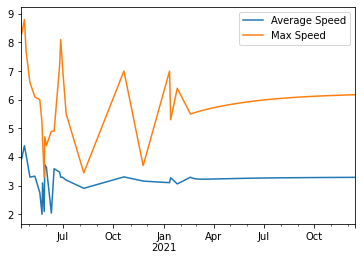

<AxesSubplot:>

In [94]:
# doing some forecasting to produce future data 
yhat = results.forecast(steps=300)
run_forecast = pd.concat([run_full[cols_of_interest], yhat], axis=0)
run_forecast.plot()

In [10]:
run.drop(['Activity ID'], axis=1).to_csv('nick_running.csv')